# Structural equation models as Linear mixed models

In [60]:
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc.sampling_jax
import scipy 

In [61]:
# read the cleaned dataset from github Dataset repository
# https://github.com/HPCurtis/Datasets/tree/main
df = pd.read_csv("https://raw.githubusercontent.com/HPCurtis/Datasets/main/mpiClean.csv", 
                 encoding= 'unicode_escape')
df

,Unnamed: 0,Country,World.region,Nutrition,Child.mortality,Years.of.schooling,School.attendance,survey,year,item,response,id,item_n,item_t,response.01
0,1.1,Armenia,Europe and Central Asia,6.103982,0.248720,0.274607,1.409905,DHS,2015-2016,1,0.027224,1,Cooking fuel,x1,0.031952
1,1.2,Armenia,Europe and Central Asia,6.103982,0.248720,0.274607,1.409905,DHS,2015-2016,2,0.234627,1,Sanitation,x2,0.234627
2,1.3,Armenia,Europe and Central Asia,6.103982,0.248720,0.274607,1.409905,DHS,2015-2016,3,0.021203,1,Drinking water,x3,0.021203
3,1.4,Armenia,Europe and Central Asia,6.103982,0.248720,0.274607,1.409905,DHS,2015-2016,4,0.000401,1,Electricity,x4,0.005397
4,1.5,Armenia,Europe and Central Asia,6.103982,0.248720,0.274607,1.409905,DHS,2015-2016,5,0.071966,1,Housing,x5,0.071966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,101.2,Niger,Sub-Saharan Africa,54.606754,18.699162,74.986184,58.207387,DHS,2012,2,0.894781,101,Sanitation,x2,0.894781
599,101.3,Niger,Sub-Saharan Africa,54.606754,18.699162,74.986184,58.207387,DHS,2012,3,0.612169,101,Drinking water,x3,0.612169
600,101.4,Niger,Sub-Saharan Africa,54.606754,18.699162,74.986184,58.207387,DHS,2012,4,0.850217,101,Electricity,x4,0.846714
601,101.5,Niger,Sub-Saharan Africa,54.606754,18.699162,74.986184,58.207387,DHS,2012,5,0.935617,101,Housing,x5,0.935617


In [62]:
# speicfy prior values and index varaibles for model below
alphaScale = 1
betaScale = np.sqrt(.25) / scipy.stats.norm.ppf(.975)
lamdaMedian = np.log(.1)
lamdaScale = np.log(.25 / .1) / scipy.stats.norm.ppf(.95) 
sigmaScale = .5 / scipy.stats.norm.ppf(.975) / scipy.stats.norm.ppf(.975)
respid = df['id'].values - 1
itemid = df['item'].values - 1
Ni = int(np.max(df['item']))
Np = int(np.max(df['id']))

In [63]:
# PYMC model
with pm.Model() as congLN:
    alpha = pm.Normal('alpha', 0, alphaScale)
    sigmaBeta = pm.HalfNormal('sigmaBeta', betaScale)
    beta = pm.Normal('beta', alpha, sigmaBeta, shape = Ni)
    lamda = pm.LogNormal('lamda', lamdaMedian, lamdaScale, shape = Ni)
    thetaP = pm.Normal('thetaP', 0, 1, shape = Np)
    sigma = pm.HalfNormal('sigma', sigmaScale, shape = Ni)
        
    #
    sigmaY = pm.Deterministic('sigmaY', sigma[itemid])
    mu = pm.Deterministic('mu', beta[itemid] + lamda[itemid] * thetaP[respid])
    # Likelihood
    y = pm.Normal('y', mu, sigmaY, observed = df['response.01']) 

In [64]:
# Sample model parameters.
with congLN:
    idata = pymc.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.474785
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.595533
Transforming variables...
Transformation time =  0:00:00.067240


In [69]:
# Check summary of PYMC model parameters.
az.summary(idata, var_names = ['alpha', 'sigmaBeta', 'beta', 'lamda', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.347,0.070,0.203,0.466,0.002,0.002,1137.0,1858.0,1.00
sigmaBeta,0.150,0.058,0.069,0.255,0.001,0.001,3067.0,2205.0,1.00
beta[0],0.512,0.034,0.446,0.575,0.002,0.001,294.0,649.0,1.01
beta[1],0.418,0.028,0.366,0.472,0.002,0.001,292.0,810.0,1.01
beta[2],0.267,0.019,0.233,0.302,0.001,0.001,294.0,707.0,1.01
beta[3],0.313,0.030,0.258,0.371,0.002,0.001,234.0,514.0,1.01
beta[4],0.388,0.028,0.339,0.444,0.002,0.001,309.0,809.0,1.01
beta[5],0.176,0.018,0.143,0.209,0.001,0.001,303.0,792.0,1.01
lamda[0],0.295,0.025,0.250,0.343,0.001,0.001,617.0,1528.0,1.01
lamda[1],0.246,0.021,0.207,0.283,0.001,0.001,635.0,1489.0,1.00


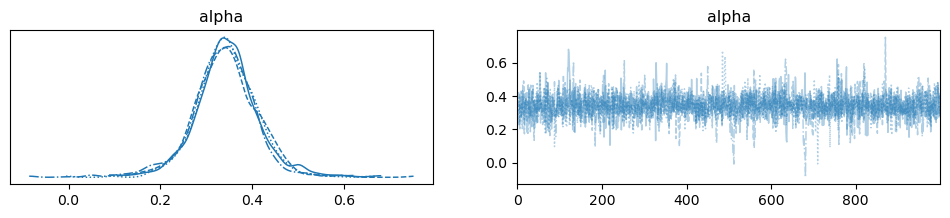

In [40]:
# Plot MCMC Trace.
az.plot_trace(idata, var_names = 'alpha');

# References